In [1]:
!pip install --upgrade --no-deps statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
eth_data = drive.CreateFile({'id': '1G8mFVFCLEs5Q1_c6jbKfXJnb32hr_e3u'})
eth_data.GetContentFile("eth_data.csv")

mean_reversion_obj = drive.CreateFile({"id": "1P133wCWwuqmuWGVuywc9NteIgDJYkq_X"})
mean_reversion_obj.GetContentFile("mean_reversion.py")

trading_obj = drive.CreateFile({"id": "1PgbKHFJ_pHBbnTG3_DLLziSqAKffS3LI"})
trading_obj.GetContentFile("trading.py")

    100% |████████████████████████████████| 993kB 21.0MB/s 


In [0]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import mean_reversion
import trading

In [0]:
def Plotting_and_Testing(params, data, plot_obj, test_obj, test_name):
    p_name = params.pair_name
    plot_obj.plot_price_series(data, p_name)
    plot_obj.plot_scatter_series(data, p_name[0], p_name[1])

    params.ols_res, params.ols_spread = test_obj.OLS_spread()
    params.j_res, params.j_spread = test_obj.Johansen(100, True)

    if test_name == "OLS":
        spread = params.ols_spread
    elif test_name == "Johansen":
        spread = params.j_spread

    plot_obj.plot_spread(spread)
    plot_obj.spread_qq_plot(spread)
    params.cadf_res = test_obj.CADF(spread, True)
    params.Hurst = test_obj.Hurst(spread)
    params.VR = test_obj.Variance_Ratio(spread, 100)
    plot_obj.plot_VR(params.VR)
    params.half_life = test_obj.half_life(spread)
    
def Only_Testing(params, data, test_obj, test_name):
    params.ols_res, params.ols_spread = test_obj.OLS_spread()
    params.j_res, params.j_spread = test_obj.Johansen(100, True)
    
    if test_name == "OLS":
        spread = params.ols_spread
    elif test_name == "Johansen":
        spread = params.j_spread

    params.cadf_res = test_obj.CADF(spread, True)
    params.Hurst = test_obj.Hurst(spread)
    params.VR = test_obj.Variance_Ratio(spread, 100)
    params.half_life = test_obj.half_life(spread)
    
def Plotting_Result(st_res, res, s_time, e_time):
    def Subplotting(data_0, x_0, y_0, title_0, data_1, x_1, y_1,  title_1):
        fig, axes = plt.subplots(1,2, sharey=True, figsize = (50, 10))
        axes[0].plot(data_0)
        axes[0].set_xlabel(x_0)
        axes[0].set_ylabel(y_0)
        axes[0].set_title(title_0)

        axes[1].plot(data_1)
        axes[1].set_xlabel(x_1)
        axes[1].set_ylabel(y_1)
        axes[1].set_title(title_1)
    
    st_res = st_res[s_time:e_time]
    res = res[s_time:e_time]
    
    Subplotting(st_results["Balance_0"], "Time", "Balance/$", "Balance in Account 0", st_results["Balance_1"], "Time", "Balance/$", "Balance in Account 1")
    Subplotting(st_results["Volume_0"], "Time", "Volume", "Volume in Account 0", st_results["Volume_1"], "Time", "Volume", "Volume in Account 1")
    Subplotting(st_results["Net_0"], "Time", "Net Profit/$", "Net Profit in Account 0", st_results["Net_1"], "Time", "Net Profit/$", "Net Profit in Account 1")
    
    fig = plt.figure(figsize = (20, 15))
    plt.plot(st_results["Single Net"])
    plt.xlabel("Time")
    plt.ylabel("Real Time Net Profit/$")
    plt.ylim([-20, 20])
    plt.title("Real Time Single Net Profit for all accounts")
    
    fig = plt.figure(figsize = (20, 15))
    plt.plot(results["Net"])
    plt.set_xlabel("Time")
    plt.set_ylabel("Cumulative Net Profit")
    plt.set_ylim((0, 500))
    plt.set_title("Cumulative Net Profit")

In [32]:
# Main Programme
# First Data Cleaning
df = pd.read_csv("eth_data.csv", engine = "c", usecols = range(1,10))
data = pd.DataFrame()
data["utc"] = df["utc"].apply(lambda x: datetime.datetime.strptime("20" + x, '%Y-%m-%d %H:%M'))
data["last_0"], data["buy_0"], data["sell_0"] = df["last.x"], df["buy.x"], df["sell.x"]
data["last_1"], data["buy_1"], data["sell_1"] = df["last.y"], df["buy.y"], df["sell.y"]
data = data.set_index("utc")
# Parameters Intialization 
params = mean_reversion.params(["last_0", "last_1"], datetime.datetime(2018, 10, 1), datetime.datetime(2019, 1, 2))

# Data Spliting 
train_data, test_data = train_test_split(data, train_size = 0.7, shuffle = False)

# Object Initialization 
plotting = mean_reversion.plotting(params.start_time, params.end_time, train_data.index)
testing = mean_reversion.Testing(train_data, params.pair_name)

# Cointegration Test 

Only_Testing(params, train_data, testing, "Johansen")
# Plotting_and_Testing(params, train_data, plotting, testing, "Johansen")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Start Time: 2018-10-01 00:00:00
End Time: 2019-01-02 00:00:00
             Trace Statistic  Criti_90%  Criti_95%  Criti_99%
NULL: r <=                                                   
0                  24.543835    13.4294    15.4943    19.9349
1                   0.004888     2.7055     3.8415     6.6349 

             Eigen Statistic  Criti_90%  Criti_95%  Criti_99%
NULL: r <=                                                   
0                  24.538947    12.2971    14.2639    18.5200
1                   0.004888     2.7055     3.8415     6.6349 

    Eigen Value
0  2.666747e-04
1  5.312303e-08 

          0         1
0  0.560900 -0.051379
1 -0.558788  0.077193
ADF static -5.947189720972714
pValue 2.1900367077279913e-07
Critical Value {'1%': -3.4304210512107756, '5%': -2.8615714034920736, '10%': -2.5667867149851658}


In [0]:
# Trading Back Test 
trading_test_data = trading.trading_data(test_data, params.pair_name, 1, 16, 2.5, 2.5).process_data(params.ols_res, params.j_res, "Johansen")

hedge_ratio = params.j_res.max_evec.tolist()

trading_var = [0, 1/16, 16] # trading_var include initial fund, scale, and time interval to clear out
st_results, results = trading.trading_test(hedge_ratio, trading_test_data, params.pair_name, trading_var).back_test([0, 0.0025], False)

AttributeError: ignored

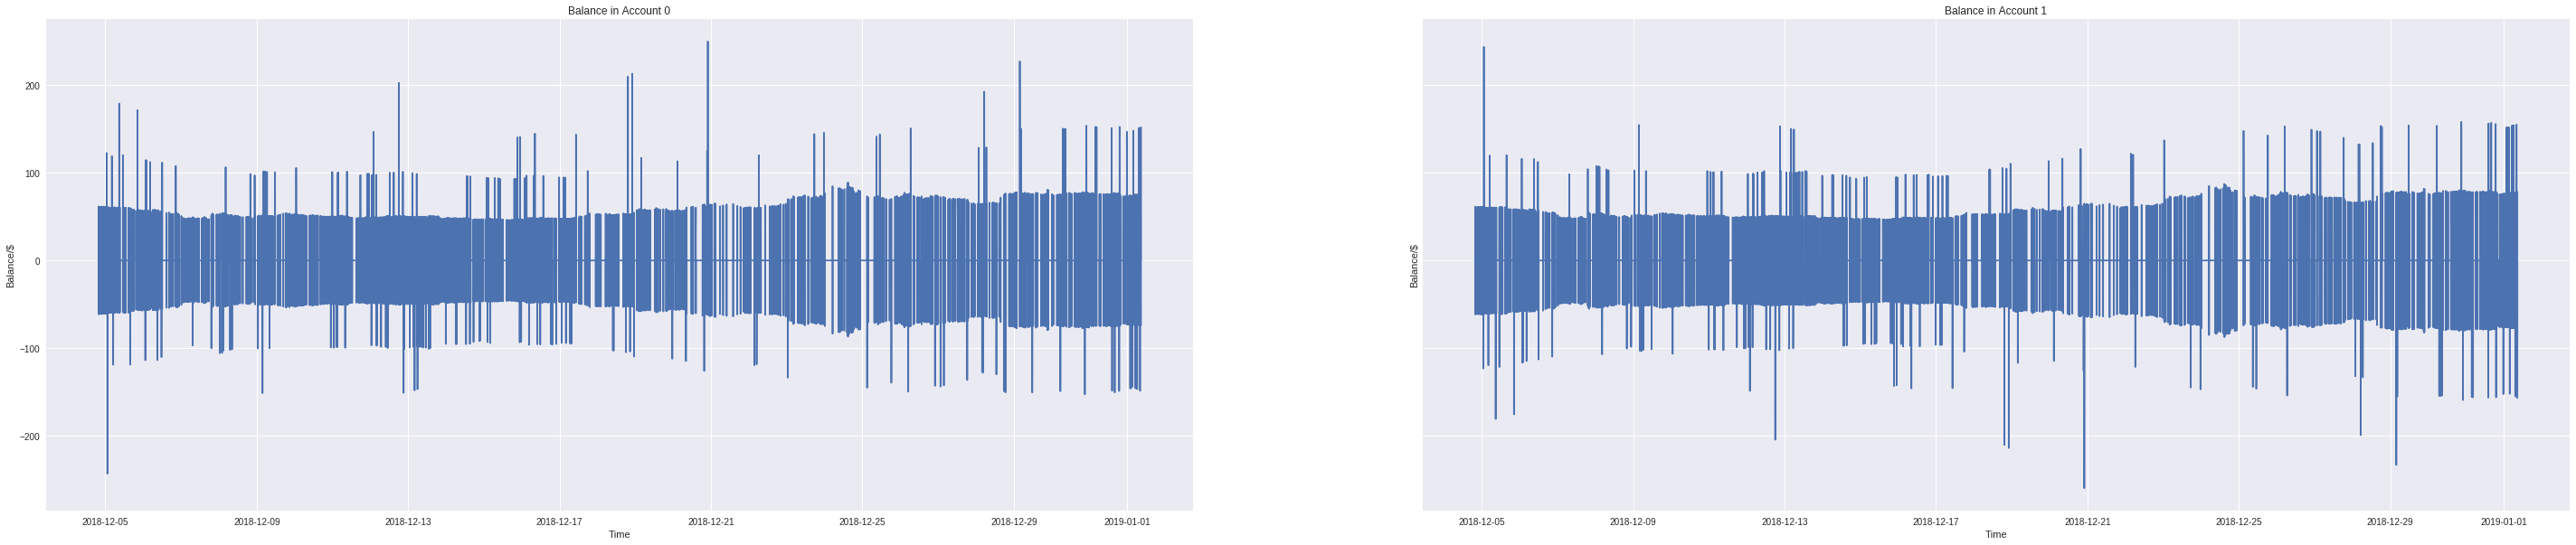

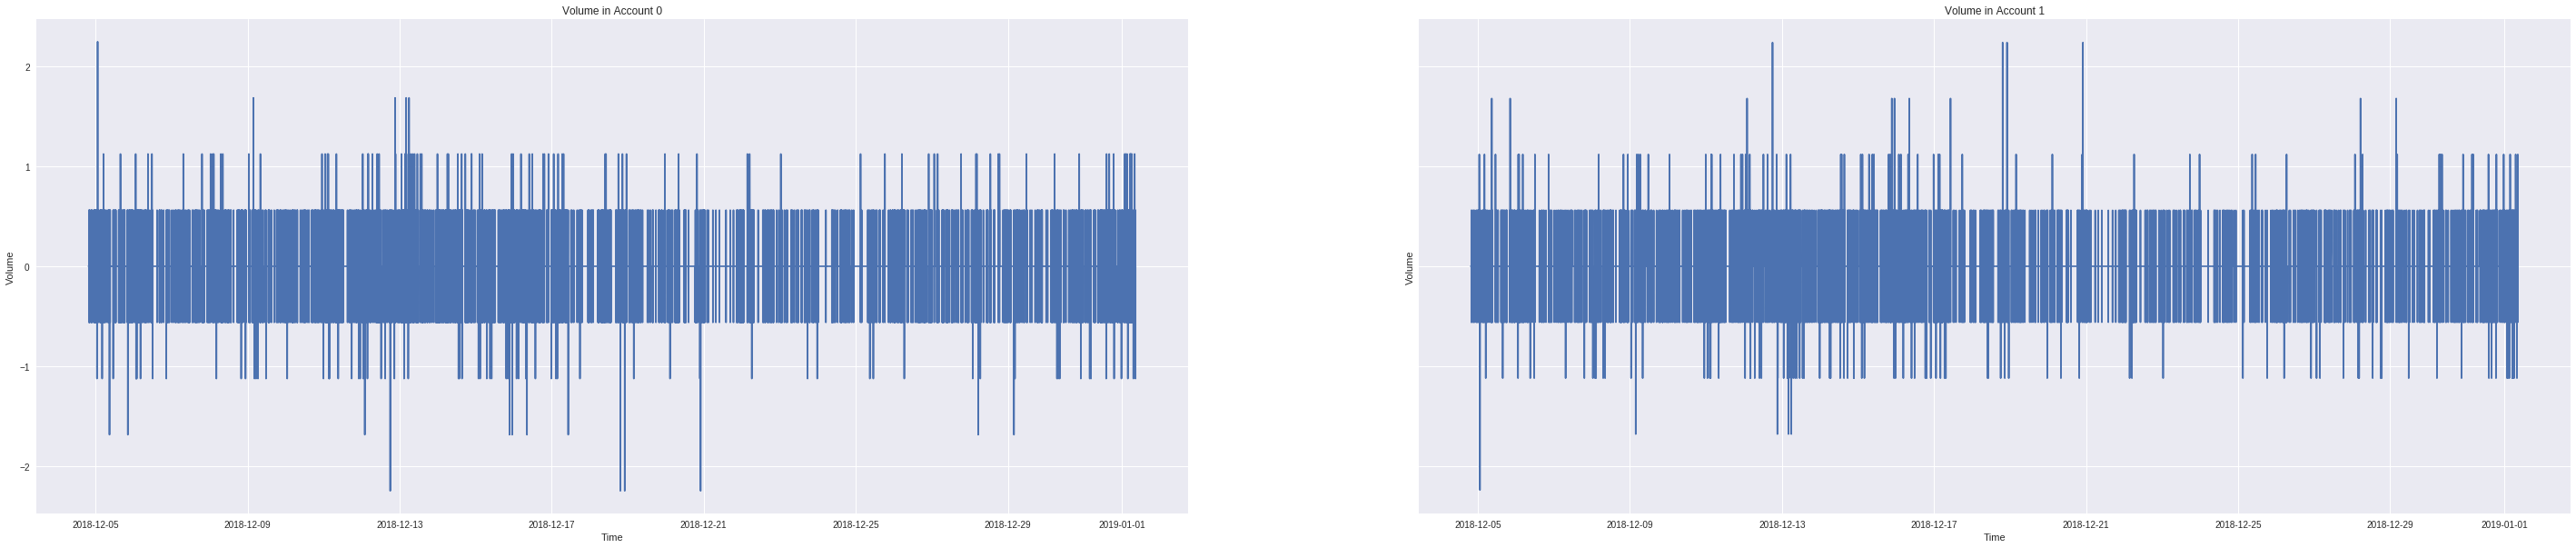

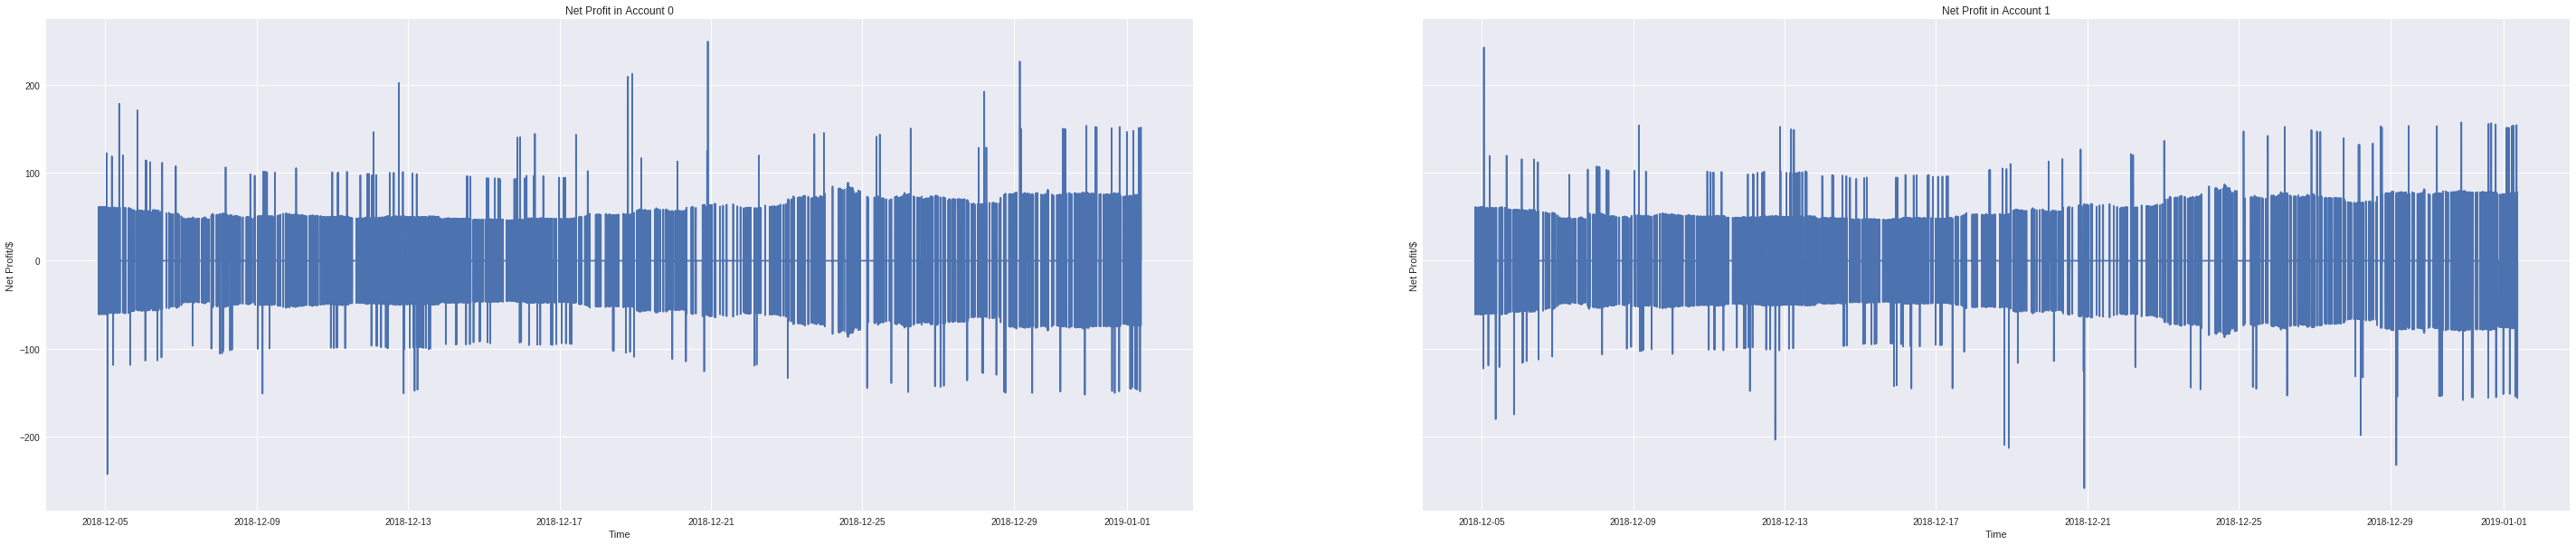

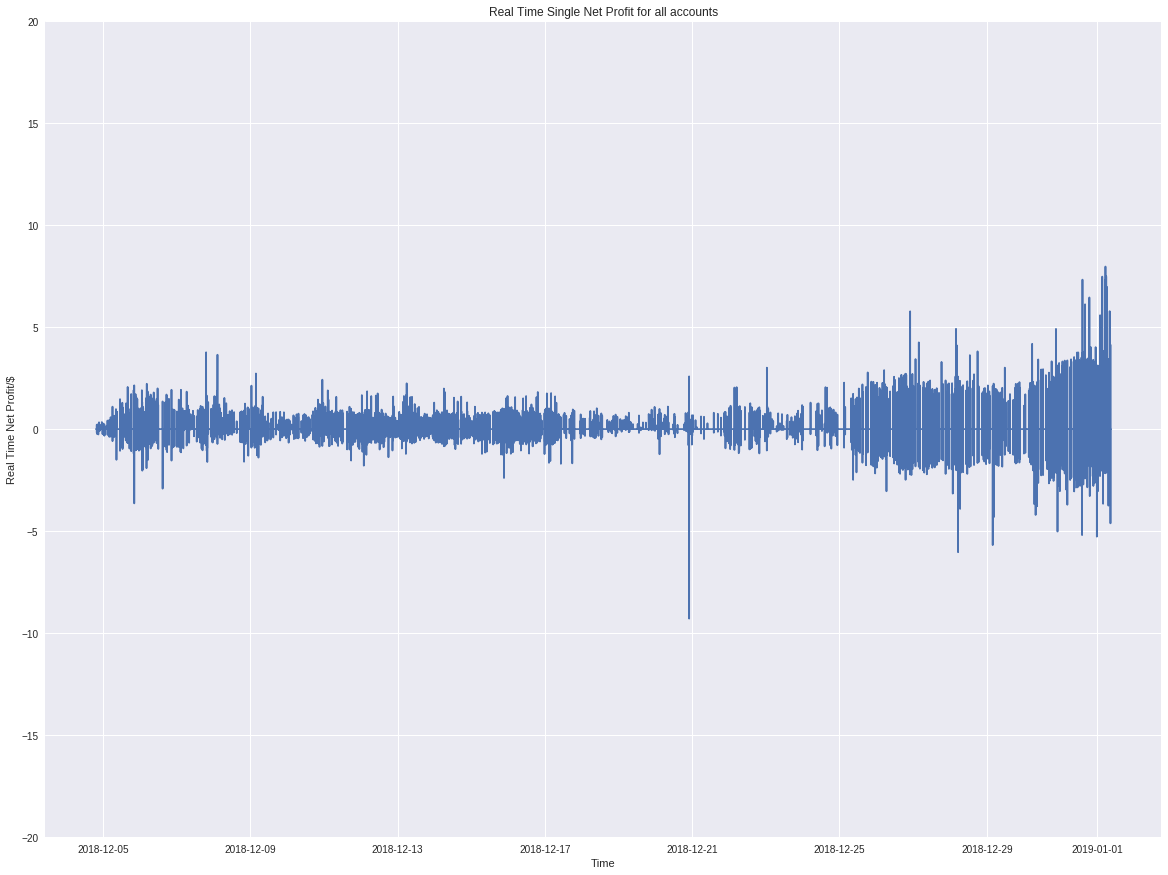

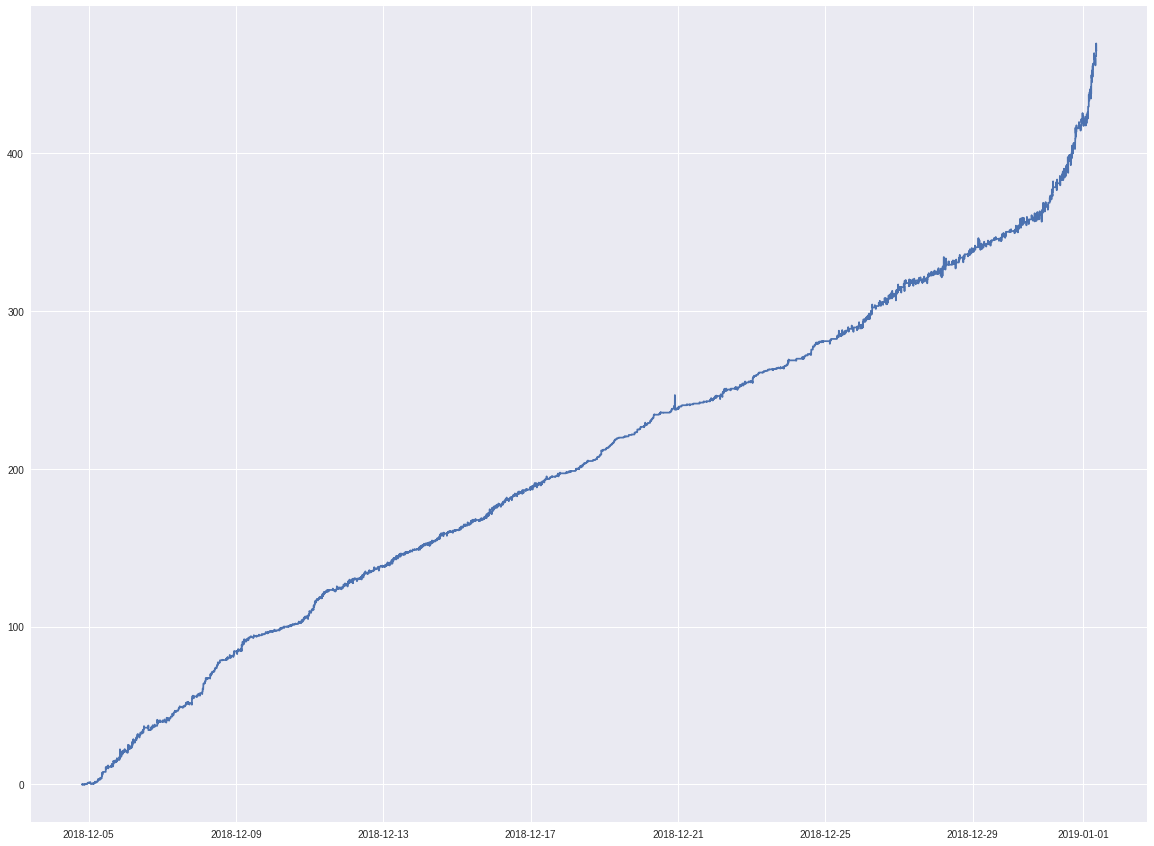

In [29]:
Plotting_Result(st_results, results, datetime.datetime(2018, 10, 1), datetime.datetime(2019, 1, 2))